In [4]:
import numpy as np
import types
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rc('axes', axisbelow=True)

from predictive_neuron import models, funs

First, we set the parameters of the neuron model. The neuronal dynamics are described by two state variables reprensenting the membrane potential and a variable encoding the output spikes. We used a discrete time-step h in the following recursive equations

$$
\begin{equation}
\begin{cases}
\label{eq:i&f_discrete}
v_t =  \alpha \, v_{t-1} - v_{\text{(th)}}s_{t-1} + \vec{w}^\top\vec{x}_t\\
s_t =  H(v_t-v_{\text{(th)}}) \,
\end{cases}
\end{equation}
$$

where $$\alpha = 1 - h/\tau_m$$

The model is defined by 5 parameters: the membrane time constant, the voltage threshold, the learning rate and the synaptic time constant.

In [6]:
'set model'
par = types.SimpleNamespace()

par.dt = .05
par.eta = 5e-4
par.tau_m = 10.
par.v_th = 2.
par.tau_x = 2.

par.bound = 'soft'

To illustrate the development of anticipatory firing for a simple example, we exposed the neuron to a sequence of two input spikes coming from two different pre-synaptic neurons that fire with a relative delay of 4 ms. We define the number of inputs N, the total lenght of the simulation T, and the timing of each input spike.

In [7]:
'set inputs'
par.N = 2
par.T = int(100/par.dt)
par.epochs = 300
timing = (np.array([2.,6.])/par.dt).astype(int)
x_data = funs.get_sequence_stdp(par,timing)

Text(0, 0.5, 'pre-syn inputs')

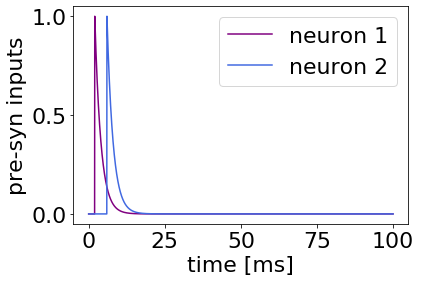

In [8]:
'visualize inputs'
plt.plot(np.arange(0,par.T*par.dt,par.dt),x_data[0,:],color='purple',label='neuron 1')
plt.plot(np.arange(0,par.T*par.dt,par.dt),x_data[1,:],color='royalblue',label='neuron 2')
plt.legend()
plt.xlabel('time [ms]')
plt.ylabel('pre-syn inputs')

We define the forward pass and the training functions

In [9]:
def forward(par,neuron,x): 
    """
    - neuron: neuron model (istance of NeuronClass from module "models")
    - x: pre-synaptic inputs, dim (N,T)
    """
    v,z = [], []
    for t in range(par.T):  
        'update weights and membrane potential - Equation 1 and Equation 3'
        neuron(x[:,t])          
        if neuron.z != 0: z.append(t*par.dt)  
        v.append(neuron.v)
    return neuron, v, z

def train(par,neuron,x):
    """
    - neuron: neuron model (istance of NeuronClass from module "models")
    - x: pre-synaptic inputs, dim (N,T)
    """
    w1, w2 = [], []
    v_list, spk_list = [], []

    for e in range(par.epochs): 
    
        neuron.state()
        neuron, v, spk = forward(par,neuron,x) 
    
        w1.append(neuron.w[0].item())
        w2.append(neuron.w[1].item())
        v_list.append(v)
        spk_list.append(spk)
    
        if e%50 == 0: print(e)  

    return w1,w2,v_list,spk_list

We trained the model by repeating the input pattern for 300 epochs of duration T = 100 ms. During the training period, the neuron learns to adjust its output spike time and to eventually fire ahead of the pre-synaptic input 2, which arrives a t 6 ms. 

In [10]:
'initialize the model'
neuron = models.NeuronClass_NumPy(par)

'set initial conditions'
neuron.w = .005*np.ones(par.N)

'train the model'
w1,w2,v,spk = train(par,neuron,x_data)

0
50
100
150
200
250


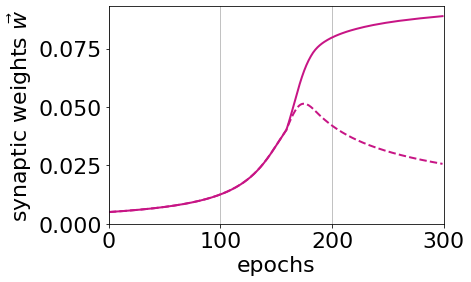

In [11]:
plt.plot(w1,color='mediumvioletred',linewidth=2)
plt.plot(w2,color='mediumvioletred',linewidth=2,linestyle='dashed')
plt.xlabel(r'epochs')
plt.ylabel(r'synaptic weights $\vec{w}$')
plt.xlim(0,par.epochs)
plt.ylim(bottom=0)
plt.grid(True,which='both',axis='x',color='darkgrey',linewidth=.7)

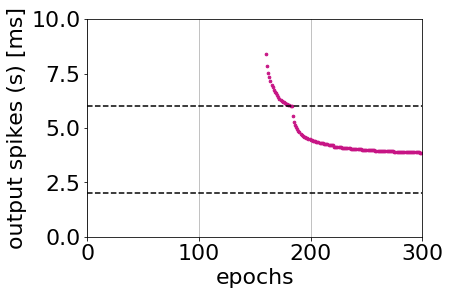

In [12]:
for k,j in zip(spk,range(par.epochs)):
    plt.scatter([j]*len(k),k,c='mediumvioletred',s=7)
plt.ylabel(r'output spikes (s) [ms]')
for k in timing*par.dt:
    plt.axhline(y=k,color='k',linewidth=1.5,linestyle='dashed')
plt.xlabel(r'epochs')
plt.xlim(0,par.epochs)
plt.ylim(0,10)
plt.grid(True,which='both',axis='x',color='darkgrey',linewidth=.7)

-----------------------------------------------------------------------------

We reproduce the results of Figure 1 in the manuscript

In [29]:
w_0 = [.005,.03,.05]

w1_tot, w2_tot = [],[]
v_tot, spk_tot = [], []   
c=['mediumvioletred','mediumslateblue','lightseagreen']

for k in range(len(w_0)):
    
    print('solving for w_0 = {}'.format(w_0[k]))
    
    'numerical solution'
    neuron = models.NeuronClass_NumPy(par)
    neuron.w = w_0[k]*np.ones(par.N)
    
    w1,w2,v,spk = train(par,neuron,x_data)
    
    w1_tot.append(w1)
    w2_tot.append(w2)
    v_tot.append(v)
    spk_tot.append(spk)

solving for $w_0$ = 0.005
0
50
100
150
200
250
solving for $w_0$ = 0.03
0
50
100
150
200
250
solving for $w_0$ = 0.05
0
50
100
150
200
250


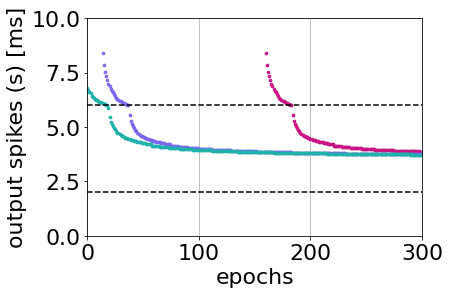

In [32]:
'output spike times across epochs'
for s in range(len(spk_tot)):
    for k,j in zip(spk_tot[s],range(par.epochs)):
        plt.scatter([j]*len(k),k,c=c[s],s=7)
plt.ylabel(r'output spikes (s) [ms]')
for k in timing*par.dt:
    plt.axhline(y=k,color='k',linewidth=1.5,linestyle='dashed')
plt.xlabel(r'epochs')
plt.xlim(0,par.epochs)
plt.ylim(0,10)
plt.grid(True,which='both',axis='x',color='darkgrey',linewidth=.7)

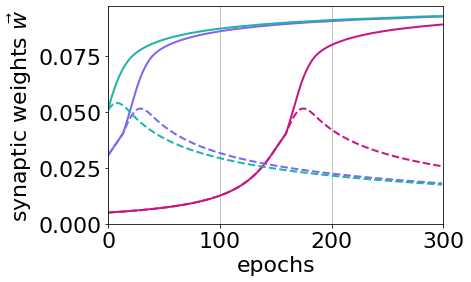

In [31]:
'output spike times across epochs'
for s in range(len(w_0)):
    plt.plot(w1_tot[s],color=c[s],linewidth=2)
    plt.plot(w2_tot[s],color=c[s],linewidth=2,linestyle='dashed')
plt.xlabel(r'epochs')
plt.ylabel(r'synaptic weights $\vec{w}$')
plt.xlim(0,par.epochs)
plt.ylim(bottom=0)
plt.grid(True,which='both',axis='x',color='darkgrey',linewidth=.7)
fig.tight_layout(rect=[0, 0.01, 1, 0.97])

Text(0.5, 0, 'time [ms]')

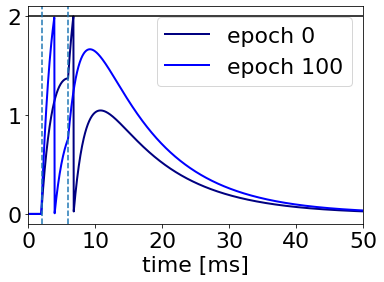

In [43]:
plt.plot(np.arange(0,par.T*par.dt,par.dt),v_tot[2][0],color='navy',linewidth=2,label='epoch 0')
plt.plot(np.arange(0,par.T*par.dt,par.dt),v_tot[2][100],color='blue',linewidth=2,label='epoch 100')
plt.xlim(0,50)
plt.axhline(y=par.v_th,color='k')
plt.axvline(x=2,linestyle='dashed')
plt.axvline(x=6,linestyle='dashed')
plt.legend()
plt.xlabel(r'time [ms]')